In [816]:
import numpy as np
import random
import math
import scipy as sci
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pandas as pd
import librosa
from librosa import display
import IPython
import collections
import jams
import string
import re
import sklearn 
from sklearn import preprocessing
from sklearn import metrics
from inspect import signature

In [401]:
# track tempo estimate
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

NameError: name 'sr' is not defined

In [133]:
import itertools
def head(dict_, n):
    return dict(itertools.islice(dict_.items(), n))

In [134]:
def exportJAM(sound_file, fail_dict, out_file):
    # Construct a new JAMS object and new annotation records
    jam = jams.JAMS()
    
    # Get the file metadata
    title = sound_file.split('/')[3].split('.')[0]
    artist = sound_file.split('/')[2].split('_')[0]
    release = sound_file.split('/')[2].split('_')[2]
    
    # Load the audio file
    y, sr = librosa.load(sound_file)

    # Get the track duration
    track_duration = librosa.get_duration(y=y, sr=sr)
    track_duration = '%.2f' % (float(track_duration))
    
    jam.file_metadata.duration = float(track_duration)
    jam.file_metadata.title = title
    jam.file_metadata.artist = artist
    jam.file_metadata.release = release
    
    fail_lyrics = jams.Annotation(namespace='lyrics', time=0) # what does time mean in this context?
    fail_lyrics.annotation_metadata = jams.AnnotationMetadata(data_source='Collecive Rap Datasets')
    
    for failling in fail_dict:
        interval = list(failling.keys())[0].split('-')
        start_time = float(interval[0])
        duration = float(interval[1]) - float(interval[0])
        duration = float('%.2f' % duration)
        
        fail_words = ''
        for f_word in list(failling.values())[0]:
            fail_words += f_word[0] + ' '
        
        fail_words = fail_words.rstrip()
        fail_lyrics.append(time=start_time, duration=duration, value=fail_words)
    
    jam.annotations.append(fail_lyrics)
    jam.save(out_file)

In [135]:
exportJAM(sound_file, fail_dict, out_file="test.jams")

NameError: name 'sound_file' is not defined

In [136]:
# visualization with fail nums
# keys = []
# nums = []
# fail_num_lst = fail_nums[:]
# for f in fail_num_lst:
#     key = f[0]
#     num = f[1]
#     keys.append(key)
#     nums.append(num)

In [137]:
# x = np.arange(len(nums))
# plt.figure(figsize=(25,15))
# plt.bar(x, height=nums)
# plt.xlabel('Words failed to be aligned', fontsize=25)
# locs, labels = plt.xticks(x, keys, rotation=90, fontsize= 20)

In [138]:
# Record the numbers of failling phonemes, try to visualize them (together with the <unk>)

# fail_phoneme_num = {}
# for k in keys:
#     if k in phoneme_dict:
#         for pho in phoneme_dict[k]:
#             if pho in fail_phoneme_num:
#                 fail_phoneme_num[pho] += 1
#             else:
#                 fail_phoneme_num[pho] = 1
#     else:
#         unknown = '<unk>'
#         if unknown in fail_phoneme_num:
#                 fail_phoneme_num[unknown] += 1
#         else:
#             fail_phoneme_num[unknown] = 1

In [139]:
# fail_phonemes_sorted = sorted(fail_phoneme_num.items(), key=lambda kv: kv[1], reverse=True)

In [140]:
# fail_phonemes = [v[0] for v in fail_phonemes_sorted]
# fail_phonemes_count = [v[1] for v in fail_phonemes_sorted]

In [141]:
# plot the failed phonemes
# x = np.arange(len(fail_phonemes))
# plt.figure(figsize=(25,15))
# plt.bar(x, height=fail_phonemes_count)
# plt.xlabel('Phonemes failed to be aligned', fontsize=25)
# locs, labels = plt.xticks(x, fail_phonemes, rotation=90, fontsize= 20)

In [142]:
# 模块化
# Goal: to see how well the alginment tool works

In [143]:
import os
from os import walk

In [144]:
# helper function for reading phoneme dictionaries
def phoneme_dict_reader(phoneme_dict_file):
    with open(phoneme_dict_file, 'r') as reader:
        lines = reader.readlines()
    
    phoneme_dict = dict()
    # extract each individual phoneme
    for line in lines:
        line = line.split()
        phoneme_dict[line[0].lower()] = line[1:]
        
    return phoneme_dict

# test
res = phoneme_dict_reader('cmudict.txt')


# construct the phoneme set 
phone_set = set()
for phonemes in res.values():
    for phone in phonemes:
        phone_set.add(phone.upper())

In [145]:
# 1. 构造compute_fail_num函数 (focus on word level)
def compute_fail_nums(path, errorRate_over_tracks):
    
    # get the track_name
    # find '/'
    start_idx = path.find('/', 8)
    track_name = path[start_idx + 1:-4] # corresponding to specific path format
    
    # read the aligned file
    with open(path, 'r') as reader:
    #     lines = reader.readlines()
        aligned_lines = json.load(reader)
        
    # compute
    # trascript
    transcript = aligned_lines['transcript']
    words = aligned_lines['words']
    
    case = 'case'
    fails = [words[i] for i in range(len(words)) if words[i][case] == 'not-found-in-audio']
    
    # 这里的话就是一个初筛
    fail_ratio = len(fails) / len(words)
    errorRate_over_tracks[track_name] = '{:.2%}'.format(fail_ratio)

In [146]:
def compute_aggregate(path, errorRate_over_tracks):
    # test on 5 algined files
    folder_prefix = path
    
    # get all the folders
    dirs = [d for d in os.listdir(folder_prefix) if os.path.isdir(folder_prefix + d) and d != '.ipynb_checkpoints']
    
    album_paths = []
    for album in dirs:
        album_paths.append(folder_prefix + album)
        
    for album_path in album_paths:
        aligned_files = [album_path + '/' + f for f in os.listdir(album_path) if os.path.isfile(album_path + '/' + f) and f.startswith('.DS') == False]
        for aligned_file in aligned_files:
            compute_fail_nums(aligned_file, errorRate_over_tracks)

    # sort the error rate based on error rate
    errorRate_over_tracks_sorted = sorted(errorRate_over_tracks.items(), key=lambda kv: float(kv[1].strip('%'))/100)
    
    # according to the threshold, select some workable tracks
    filtered_tracks = list(filter(select_tracks, errorRate_over_tracks_sorted))
    
    return filtered_tracks

In [147]:
def select_tracks(track):
    if float(track[1].strip('%')) / 100 < 0.18:  # 0.18 as threshold
        return True
    else:
        return False

In [148]:
# collection info of error rate for each tracks
errorRate_over_tracks = {}

In [149]:
compute_aggregate('data/aligned/', errorRate_over_tracks)

[('Criminal/sponsor_aligned', '1.51%'), ('Criminal/9mm_aligned', '6.82%')]

In [187]:
def compute_phone_timestamp(TYPE, aligned_phones, start_time, durations, phonemes, resolution):
    '''
        Returns a list the phonemes while keeping track of the start time of each phoneme
    '''
    
    precision = 0.001
    
    if TYPE == 'full':
    
        n = min(len(durations), len(phonemes))

        s = round(start_time, 3)
        aligned_phones[round(s - precision, 3)] = 'START'
        aligned_phones[s] = phonemes[0]


        for i in range(n - 1):
            # take care of the round off error
            next_s = round(start_time + durations[i], 3)
            aligned_phones[round(next_s - precision, 3)] = phonemes[i]
            aligned_phones[next_s] = phonemes[i + 1]
            start_time += durations[i]
        
        
        e = round(start_time + durations[-1], 3)
        aligned_phones[round(e - precision, 3)] = phonemes[n - 1]
        aligned_phones[e] = 'END'
        
    elif TYPE == 'half':
        
        time_interval = round(durations[0] - start_time, 3)
        
        n = len(phonemes)

        step = time_interval / n
        
        if time_interval < resolution or phonemes == ['UNK']:
            s = round(start_time, 3)
            e = round(durations[0], 3)
            aligned_phones[s] = 'UNK'
            aligned_phones[e] = 'UNK'
        else:  
            s = round(start_time, 3)
            aligned_phones[round(s - precision, 3)] = 'START'
            aligned_phones[s] = phonemes[0]

            for i in range(1, n):
                # take care of the round off error
                next_s = round(start_time + step, 3)
                aligned_phones[round(next_s - precision, 3)] = phonemes[i - 1]
                aligned_phones[next_s] = phonemes[i]
                start_time += step
            
            e = round(start_time + step, 3)
            aligned_phones[round(e - precision, 3)] = phonemes[n - 1]
            aligned_phones[e] = 'END'
            
    elif TYPE == 'not-found':
        
        s = round(start_time, 3)
        e = round(durations[0], 3)
        
        aligned_phones[s] = 'UNK'
        aligned_phones[e] = 'UNK'

In [188]:
# specify some necessary parameters
hop_len = 1024
win_len = 2048
resolution = hop_len / 44100

In [189]:
# test
phoneme_dict = phoneme_dict_reader('cmudict.txt')
aligned_phones = dict()
start_time = 25.97
durations = [0.09, 0.12, 0.1]
phonemes = phoneme_dict['job']
compute_phone_timestamp('full', aligned_phones, start_time, durations, phonemes, resolution)
aligned_phones

{25.969: 'START',
 25.97: 'JH',
 26.059: 'JH',
 26.06: 'AA1',
 26.179: 'AA1',
 26.18: 'B',
 26.279: 'B',
 26.28: 'END'}

In [225]:
def get_aligned_track(path, aligned_track_phones, aligned_track_words, misalligned_track_words):
    '''
        Get the aligned track information together with misalligned information
    '''
    # find '/'
    start_idx = path.find('/', 8)
    track_name = path[start_idx + 1:-4] # corresponding to specific path format
    
    # read the aligned file
    with open(path, 'r') as reader:
    #     lines = reader.readlines()
        aligned_lines = json.load(reader)
        
    # compute
    # trascript
    transcript = aligned_lines['transcript']
    words = aligned_lines['words']
    case = 'case'
    
    aligned_track_words[track_name] = dict()
    misalligned_track_words[track_name] = dict()
    aligned_track_phones[track_name] = dict()
    aligned_track_phones[track_name][0.0] = 'START'

    phoneme_dict = phoneme_dict_reader('cmudict.txt')
    
    # compute alignment info and mis-aligned info
    start_word = 'start'
    fail_interval = ''
    fail_words = []
    flag = True
    for i in range(len(words)):
        word = words[i]
        case = word['case']
        if case == 'success':
            # need to compute the misalignment first
            if not flag:
                fail_interval += '%.2f' % (word['start'])
                flag = True
                misalligned_track_words[track_name][fail_interval] = fail_words
                aligned_track_words[track_name][fail_interval] = fail_words
                found = fail_interval.find('-')
                fail_start = float(fail_interval[:found])
                fail_end = float(fail_interval[found+1:])
                # for words not get aligned, we label it as unknown
                compute_phone_timestamp('not-found', aligned_track_phones[track_name], fail_start, [fail_end], ['UNK'], resolution)
                fail_interval = ''
                fail_words = []
            
            # for computing successfully aligned words
            success_start_time = word['start']
            success_start = '%.2f' % word['start']
            success_end_time = word['end']
#             success_time_interval = '%.2f' % (success_start) + '-' + '%.2f' % (success_end)
            aligned_track_words[track_name][success_start] = []

            aligned_word = word['alignedWord']
            # if the aligned word is recorded, then we need to keep track of the start time of each phoneme, 
            # otherwise we just do the uniform interpolation
            if aligned_word == '<unk>':
                w = word['word']
                if w.lower() in phoneme_dict:
                    phonemes = phoneme_dict[w.lower()]
                else:
                    phonemes = ['UNK']
                aligned_track_words[track_name][success_start].append((w, phonemes))
                compute_phone_timestamp('half', aligned_track_phones[track_name], success_start_time, [success_end_time], phonemes, resolution)
                
            else:
                phones = word['phones']
                durations = [p['duration'] for p in phones]
                phonemes = phoneme_dict[aligned_word.lower()]
                compute_phone_timestamp('full', aligned_track_phones[track_name], success_start_time, durations, phonemes, resolution)
                aligned_track_words[track_name][success_start].append((aligned_word, phonemes))
        
        elif case == 'not-found-in-audio':
            if flag and not i: # if the first word is not successfully aligned, then the start time will be 'start'
                fail_interval += 'start-'
            elif flag and i:
                fail_interval += '%.2f' % (words[i - 1]['end']) + '-'
#                 fail_start += '%.2f' % (words[i - 1]['end'])
            flag = False
            fail_word = word['word']
            if fail_word.lower() in phoneme_dict:
                fw, fail_phonemes = fail_word, phoneme_dict[fail_word.lower()]
            else:
                fw, fail_phonemes = fail_word, ['UNK']
            fail_words += [(fw, fail_phonemes)]
    
    
#     # tail case if the last several alignments are incorrect and never met 'succuess'
    if fail_words and case != 'success':
#         fail_interval += 'end'
        flag = True
        misalligned_track_words[track_name][fail_start] = fail_words
        fail_interval = ''
        fail_words = []
        
#     # miss alignment statistics
#     for vals in fail_dict.values():
#         for val in vals:
#             word = val.lower()
#             fail_nums[word] = fail_nums.get(word, 0) + 1
    

In [226]:
# test for get phoeneme sequence
path = 'data/aligned/Criminal/sponsor_aligned.txt'
aligned_track_info = {} # including phonemes that are corrected
misaligned_track_info = {}
aligned_track_phones = {}
get_aligned_track(path, aligned_track_phones, aligned_track_info, misaligned_track_info)

In [228]:
# aligned_track_info
# aligned_track_phones
# misaligned_track_info

In [229]:
def get_syllable_sequences(aligned_track_phonemes):
    '''
    Returns a sequence of syllables for each aligned word
    '''
    track_aligned_syllables = dict()
    for track_name, aligned_sequence in aligned_track_phonemes.items():
        track_aligned_syllables[track_name] = dict()
        for time_stamp, word_sequences in aligned_sequence.items():
            syllable_sequences = []
            track_aligned_syllables[track_name][time_stamp] = []
            for word_phone_pair in word_sequences:
                last_syllable = get_last_syllable(word_phone_pair)
                syllable_sequences.append(last_syllable)
                track_aligned_syllables[track_name][time_stamp].append((word_phone_pair[0], last_syllable))
        
    return track_aligned_syllables

In [230]:
def get_last_syllable(word_phone_pair):
    '''
        Returns the last syllable of a word
    ''' 
    import re
    
    last_syllable = ''
    phonemes = word_phone_pair[1]
    for phone in phonemes:
            if re.sub(r'\d', '', phone) in VOWELS:
                last_syllable = ''
            last_syllable += phone
    return last_syllable

In [231]:
def get_phone_type(phone_set):
    '''
    Returns the phone type for a given track
    '''
    VOWELS = ['AA', 'AE', 'AH', 'AO', 'AW', 'AX', 'AY', 'EH', 'ER', 'EY', 'OW', 'OY', 'IH', 'IY', 'IX', 'UW', 'UX', 'UH']
    phone_type = collections.defaultdict(set)
    for phone in phone_set:
        phone = phone.upper()
        # edge case
        if phone == 'AH)':
            phone = 'AH'
        # ignore the stress label    
        phone = re.sub('\d|\W', '', phone)
        if phone in VOWELS:
            phone_type['VOWEL'].add(phone)
        else:
            phone_type['CONSONANT'].add(phone)

    return phone_type

# 这里可以做不同的experimentation(只考虑vowels vs 只考虑vowels/consonants, or 加不加stress label)
phone_type = get_phone_type(phone_set)
vowels = list(phone_type['VOWEL'])
vowels.sort()
consonants = list(phone_type['CONSONANT'])
consonants.sort()
phone_classes = vowels + consonants

In [232]:
len(phone_classes)

42

In [246]:
def get_aligned_phone_seq(aligned_track_phones):
    '''
        Returns the aligned phoneme sequence for a given track together with the list of timestamps
    '''
    aligned_phone_seq = []
    aligned_timestamp =[]
    for path, time_phone_pair in aligned_track_phones.items():
        time_phone_pair = [(u, v) for u, v in time_phone_pair.items()]
        time_phone_pair.sort(key=lambda k: k[0])
        for time_stamp, phone in time_phone_pair:
            aligned_timestamp.append(time_stamp)
            aligned_phone_seq.append(phone)
    
    return np.array(aligned_timestamp), np.array(aligned_phone_seq)

In [247]:
def get_sampled_phone_seq(aligned_timestamp, aligned_phone_seq, sample_interval):
    '''
        Returns the sampled aligned sequence under given sample interval
    '''
    
    
    n = min(len(aligned_timestamp), len(aligned_phone_seq))
    
    sampled_phone_seq = []
    sampled_timestamp = []
    
    for i in range(0, n, sample_interval):
        sampled_phone_seq.append(aligned_phone_seq[i])
        sampled_timestamp.append(aligned_timestamp[i])

    
    return np.array(sampled_timestamp), np.array(sampled_phone_seq)

In [248]:
aligned_timestamp, aligned_phone_seq = get_aligned_phone_seq(aligned_track_phones)

In [251]:
# aligned_phone_seq
# aligned_timestamp

In [236]:
# compute audio features

In [252]:
def compute_mfcc(path, sr):
    '''
        Returns the mfcc feature for the given audio
    '''
    # read audio signal
    y, sr = librosa.load(path, sr=sr)

    # compute the mfcc and get the duration
    mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=14, n_fft=2048, hop_length=1024)
    duration = librosa.core.get_duration(y=y, sr=sr, n_fft=2048, hop_length=1024)
    
    return mfcc, duration

In [253]:
audio_path = 'data/vocals/Criminal/sponsor/vocals.wav'
mfcc_feature, duration = compute_mfcc(audio_path, 44100)

In [254]:
mfcc_feature.shape

(14, 10157)

In [255]:
aligned_phone_seq = np.append(aligned_phone_seq, 'END')
aligned_timestamp = np.append(aligned_timestamp, duration)

In [267]:
def get_phone_encoding(phone, phone_classes):
    '''
        Returns the phone encoding
    '''
    
    if phone == 'UNK' or phone == 'START' or phone == 'END':
        ohe_vector = np.array([np.nan for _ in range(len(phone_classes))])
    else:
        phone_vector = np.array(phone_classes)
        ohe_vector = np.where(phone_vector == phone , 1, 0)
    
    return ohe_vector

In [268]:
def compute_feature_matrix(phone_seq, phone_classes):
    '''
        Returns the feature matrix (using one-hot encoder from sklearn)
    '''
    
    n = len(phone_seq)
    size = len(phone_classes)
    
    
    feature_matrix = None
    count = 0
    
    for i in range(n):
        phone = phone_seq[i]
        # ignore the stress label 
        phone = re.sub('\d|\W', '', phone)
        feature_vector = get_phone_encoding(phone, phone_classes)
        if feature_matrix is None:
            feature_matrix = feature_vector
        else:
            feature_matrix = np.vstack((feature_matrix, feature_vector))
    
    return feature_matrix.T

In [399]:
fm = compute_feature_matrix(aligned_phone_seq, phone_classes)
fm.shape

(42, 2903)

In [270]:
# create the interpolation function
func = sci.interpolate.interp1d(aligned_timestamp, fm, axis=1)

In [260]:
def compute_SM_dot(X,Y):
    """Computes similarty matrix from feature sequences using dot (inner) product
    Notebook: C4/C4S2_SSM.ipynb
    """    
    S = np.dot(np.transpose(Y),X) 
#     S = np.matmul(np.transpose(Y), X)
    return S

In [261]:
phoneme_SSM = compute_SM_dot(fm, fm)
phoneme_SSM.shape

(2903, 2903)

In [264]:
def plot_feature_SSM(SSM):
    ax = sns.heatmap(SSM, vmin=0, vmax=1, cmap='BuPu')
    ax.invert_yaxis()
    sns.set(rc={'figure.figsize':(14,12)})

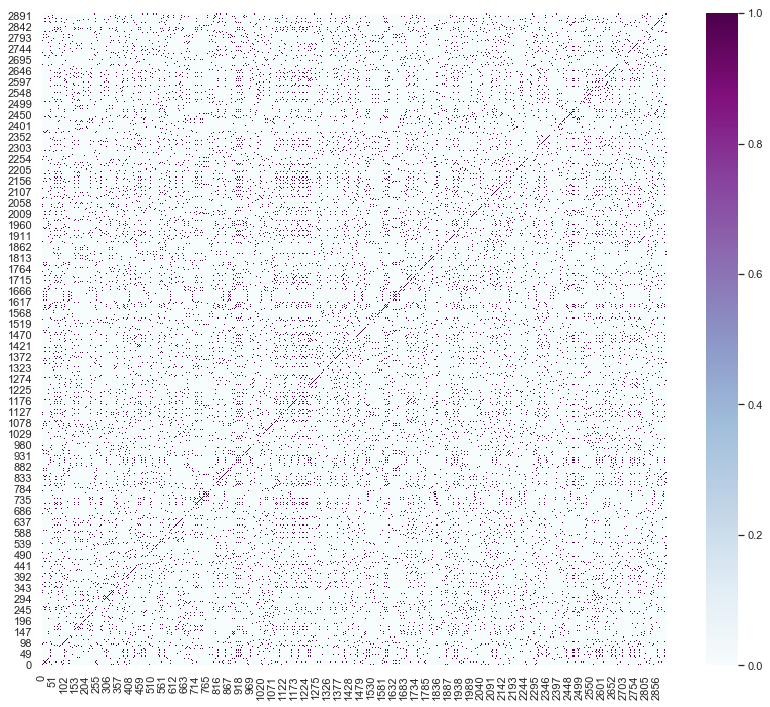

In [265]:
plot_feature_SSM(phoneme_SSM)

In [562]:
def get_valid_indices(SSM):
    '''
        Returns the indices of valid outputs from SSM and remove the nan indices
    '''

    rows, cols = np.triu_indices_from(SSM, k = 1)
    nan_pair = np.argwhere(np.isnan(SSM))
    set1 = set([(u ,v) for u, v in zip(rows, cols)])
    set2 = set(list(map(tuple, nan_pair)))
    
    return set1 - set2

In [941]:
def get_pair(SSM, valid_indices, hop_len, aligned_timestamp, threshold):
    '''
        Returns the indices of the rhyming pair and non-rhyming pair on phonemes
    '''
    
    rhyming_pair = set()
    non_rhyming_pair = set()
    
    for u, v in valid_indices:
        t1 = aligned_timestamp[u]
        t2 = aligned_timestamp[v]
        if abs(t2 - t1) >= threshold or abs(t2 - t1) < 0.2: # set up a threshold 
            continue
        if phoneme_SSM[u, v] == 1.0:
            rhyming_pair.add((u, v))
        else:
            non_rhyming_pair.add((u, v))

    return rhyming_pair, non_rhyming_pair

In [942]:
valid_indices = get_valid_indices(phoneme_SSM)

In [943]:
rhyming_pair, non_rhyming_pair = get_pair(phoneme_SSM, valid_indices, hop_len, aligned_timestamp, 5.0)

In [944]:
# initialization
anlysis_report = dict()

In [945]:
def match_resolution(aligned_phone_seq, aligned_timestamp, sample_interval, i, j, hop_len):
    '''
        Match the resolution between sub part of phoneme SSM and mfcc SSM
    '''
    start_idx = i * sample_interval
    end_idx = j * sample_interval

    # get the part of aligned phoneme sequences and timestamps
    phone_seq = aligned_phone_seq[start_idx:end_idx + 1]
    timestamp_seq = aligned_timestamp[start_idx:end_idx + 1]
    
    start_time = timestamp_seq[0]
    end_time = timestamp_seq[-1]
    
    resolution = hop_len / 44100
    
    n = min(len(phone_seq), len(timestamp_seq))
    
    sub_feature_matrix = None
    
    for k in range(n - 1):
        p1 = phone_seq[k]
        p2 = phone_seq[k + 1]
        t1 = float(timestamp_seq[k])
        t2 = float(timestamp_seq[k + 1])
             
        if sub_feature_matrix is None:
            sub_feature_matrix = make_matched_fm(p1, p2, t1, t2, phone_classes, resolution)
        else:
            sub_feature_matrix = np.vstack((sub_feature_matrix, make_matched_fm(p1, p2, t1, t2, phone_classes, resolution)))
            
    return sub_feature_matrix.T

In [946]:
def make_matched_fm(p1, p2, t1, t2, phone_classes, resolution):
    v1 = get_phone_encoding(p1, phone_classes)
    v2 = get_phone_encoding(p2, phone_classes)
    
    time_interval = round(t2 - t1, 2)
    
    
    if time_interval < resolution:
        fm = get_phone_encoding(p1, phone_classes)
        return fm
    
    cols = math.floor(time_interval / resolution) + 1
    size = len(phone_classes)
    
    f1 = get_phone_encoding(p1, phone_classes)
    f2 = get_phone_encoding(p2, phone_classes)
    
    # initiate the interpolation matrix
    interpolate_fm = np.zeros((size, cols))
    
    
    interpolate_fm[:, 0] = f1
#     interpolate_fm[:, cols-1] = f2
    
    if p1 == 'END':
        for c in range(1, cols - 1):
            interpolate_fm[:, c] = f1
    
    else:
        x = np.array([0, cols - 1])
        y = np.array([f1, f2])
        y = y.T
        # create interpolate function
        func = sci.interpolate.interp1d(x, y, kind='nearest', axis=1)

        for c in range(1, cols - 1):
            interpolate_fm[:, c] = func(c)
    
    return interpolate_fm.T
    

In [947]:
def plot_matrix(m):
    '''
        Plot the matrix
    '''
    librosa.display.specshow(m)
    plt.colorbar()
    
def threshold(y_preds):
    '''
        Returns the threshold of the classifier
    '''
    res = np.where(y_preds>0.6, 1, 0)
    
    return res


def plot_pr_curve(y_labels, y_preds):
    '''
        compute the precision and recall with varing thresholds and plot them
    '''
    precision, recall, threshold = metrics.precision_recall_curve(y_labels, y_preds)
    
    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

In [959]:
def require_analysis_report(analysis_report, mfcc_feature, rhyming_pair, aligned_phone_seq, aligned_timestamp, func, hop_len):
    
    '''
        Returns the analysis report for rhyming pair
    '''
    
    step = hop_len / 44100
    
    n =  10
    ramdon_selected_pairs = random.sample(rhyming_pair, k=n)
    
    for u, v in ramdon_selected_pairs:
        
        start_time = aligned_timestamp[u]
        end_time = aligned_timestamp[v]
        
        start_frame = math.floor(start_time / step)
        end_frame = math.floor(end_time / step) + 1
        frame_num = end_frame - start_frame
        
        time = np.arange(start_time, end_time, step)
        
        if len(time) + 1 == end_frame - start_frame:
            time = np.append(time, time[-1] + step)
        
        sub_mfcc = mfcc_feature[:,start_frame:end_frame]
        
        distance_matrix = sci.spatial.distance.cdist(sub_mfcc.T, sub_mfcc.T, metric='seuclidean')
#         print(distance_matrix.shape)
        
        # gaussian kernel
        sub_mfcc_ssm = np.exp(-distance_matrix ** 2 / 2 ** 10)
        
#         plot_matrix(sub_mfcc_ssm)
        
        interpolated_phone_seq = func(time)
        
        interpolated_ssm = compute_SM_dot(interpolated_phone_seq, interpolated_phone_seq)
#         plot_matrix(interpolated_ssm)

        # get the corresponding valid indices and compute the evaluation metrics
        indices = get_valid_indices(interpolated_ssm)
        rows = np.array([p[0] for p in indices])
        cols = np.array([p[1] for p in indices])
        
        if len(rows) and len(cols):
            y_labels = interpolated_ssm[rows, cols].astype(int)
            y_preds = sub_mfcc_ssm[rows, cols]

            precision, recall, f_beta_score, support = sklearn.metrics.precision_recall_fscore_support(y_labels, threshold(y_preds), pos_label=1, average='binary')

            analysis_report[(start_time, end_time)] = dict()
            analysis_report[(start_time, end_time)]['precision'] = precision
            analysis_report[(start_time, end_time)]['recall'] = recall
            analysis_report[(start_time, end_time)]['f_beta_score'] = f_beta_score

            plot_pr_curve(y_labels, y_preds)
        

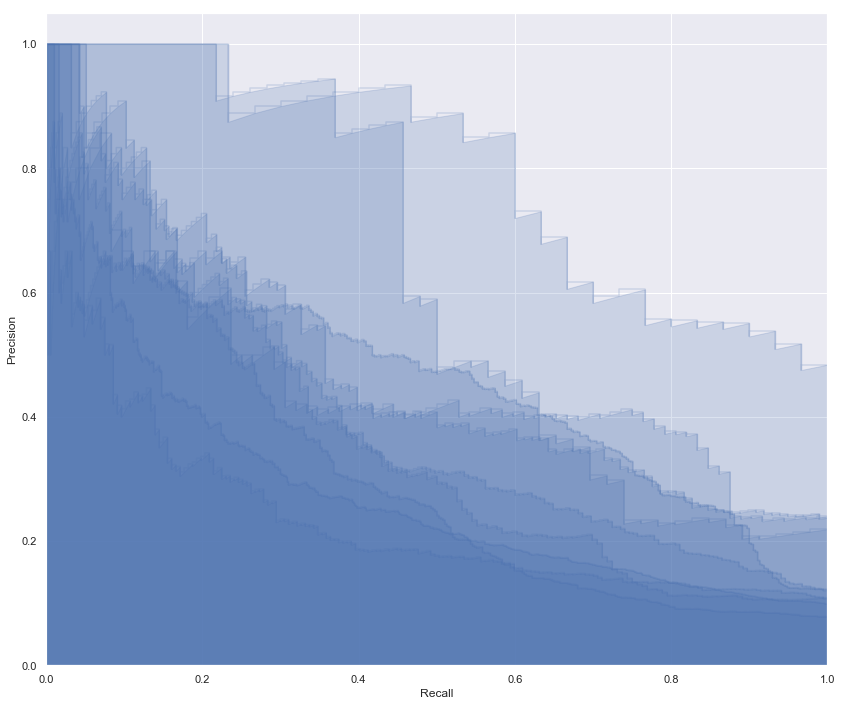

In [960]:
anlysis_report.clear()
require_analysis_report(anlysis_report, mfcc_feature, rhyming_pair, aligned_phone_seq, aligned_timestamp, func, 1024)

In [953]:
anlysis_report

{(87.73, 90.289): {'precision': 0.2390158172231986,
  'recall': 0.6666666666666666,
  'f_beta_score': 0.351875808538163},
 (156.67, 158.04): {'precision': 0.3090909090909091,
  'recall': 0.5666666666666667,
  'f_beta_score': 0.39999999999999997},
 (42.38, 44.16): {'precision': 0.29620253164556964,
  'recall': 0.5545023696682464,
  'f_beta_score': 0.38613861386138615},
 (86.78, 87.889): {'precision': 0.3883495145631068,
  'recall': 0.5517241379310345,
  'f_beta_score': 0.4558404558404558},
 (157.72, 159.11): {'precision': 0.1875,
  'recall': 0.5094339622641509,
  'f_beta_score': 0.27411167512690354},
 (101.949, 105.472): {'precision': 0.1504315659679408,
  'recall': 0.5907990314769975,
  'f_beta_score': 0.2398034398034398},
 (84.07, 87.6): {'precision': 0.19444444444444445,
  'recall': 0.561822125813449,
  'f_beta_score': 0.28890128276631344},
 (102.859, 106.079): {'precision': 0.14755244755244756,
  'recall': 0.6011396011396012,
  'f_beta_score': 0.23694553621560924},
 (93.139, 97.41):